# Challenge#6: How can we improve the performance of this car price prediction model? 

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

## The automobiles dataset 

In [2]:
df_automobiles = pd.read_csv('../data/autos.csv')

X = df_automobiles.loc[:, df_automobiles.columns != 'price'].values
y = df_automobiles['price'].values

In [4]:
df_automobiles.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


## Helper functions 

In [3]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

## Feature importance using Mutual Information

In [4]:
X = df_automobiles.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

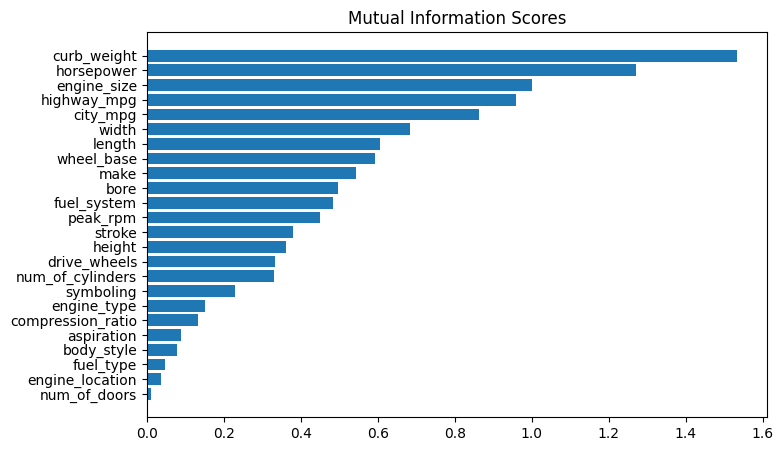

In [5]:
mi_scores = make_mi_scores(X, y, discrete_features)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

## Feature selection 

In [6]:
df_automobiles_small = df_automobiles[['curb_weight', 'horsepower', 'make', 'price']]
df_automobiles_small.head()

,curb_weight,horsepower,make,price
0,2548,111,alfa-romero,13495
1,2548,111,alfa-romero,16500
2,2823,154,alfa-romero,16500
3,2337,102,audi,13950
4,2824,115,audi,17450


## One-hot encoding the manufacturing company

In [7]:
df_automobiles_small_make_one_hot_encoded = df_automobiles_small.copy()
df_automobiles_small_make_one_hot_encoded = pd.get_dummies(df_automobiles_small_make_one_hot_encoded, columns=['make'])
df_automobiles_small_make_one_hot_encoded

,curb_weight,horsepower,price,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,...,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo
0,2548,111,13495,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2548,111,16500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2823,154,16500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2337,102,13950,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2824,115,17450,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,2952,114,16845,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
189,3049,160,19045,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
190,3012,134,21485,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
191,3217,106,22470,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Fitting a Ridge Regression after applying standard scaling

In [8]:
alphas = np.logspace(-3, 1, num=30)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-03, 1.37382380e-03, 1.88739182e-03, 2.59294380e-03,
       3.56224789e-03, 4.89390092e-03, 6.72335754e-03, 9.23670857e-03,
       1.26896100e-02, 1.74332882e-02, 2.39502662e-02, 3.29034456e-02,
       4.52035366e-02, 6.21016942e-02, 8.53167852e-02, 1.17210230e-01,
       1.61026203e-01, 2.21221629e-01, 3.03919538e-01, 4.17531894e-01,
       5.73615251e-01, 7.88046282e-01, 1.08263673e+00, 1.48735211e+00,
       2.04335972e+00, 2.80721620e+00, 3.85662042e+00, 5.29831691e+00,
       7.27895384e+00, 1.00000000e+01])))])

##  K-fold cross validation

In [9]:
cv_results = cross_validate(
    model, X, y,
    return_estimator=True, n_jobs=2)
score = cv_results["test_score"]
print(f"R2 score: {score.mean():.3f} ± {score.std():.3f}")

R2 score: 0.557 ± 0.242
